In [ ]:
!nvidia-smi

Wed Jun 25 20:52:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
#from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Establecer una semilla.

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Hace más lento, pero reproducible

set_seed()

Definimos la función que queremos modelar

In [ ]:
x = np.arange(-20,20,0.1)
y = 20*np.sin(x)*np.power(x,3)
ruido =  np.random.normal(0,100,len(x))
y = y + ruido

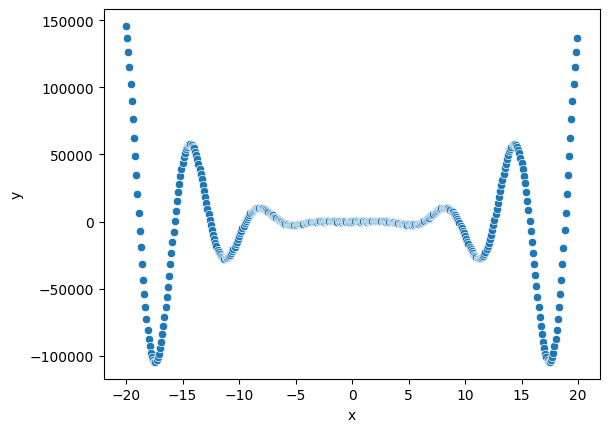

In [ ]:
datos = pd.DataFrame({"x":x, "y":y})
sns.scatterplot(datos, x = "x", y="y")
plt.show()

Dividimos los datos en entrenamiento y validación

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

Estandarizamos la distribución de los datos

In [ ]:
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train.reshape(-1, 1))
x_val_scaled = ss.transform(x_val.reshape(-1, 1))

Pytorch necesita trabajar SIEMPRE con tensores. Entonces pasamos los datos a tensores.

In [ ]:
X_train = torch.tensor(x_train_scaled, dtype=torch.float32).to("cuda")
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to("cuda")
X_val = torch.tensor(x_val_scaled, dtype=torch.float32).to("cuda")
y_val = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to("cuda")

definimos una red con una única neurona.

In [ ]:
class LinearRegr(nn.Module):
    """Equivalente a una regresión lineal"""
    def __init__(self):
        super(LinearRegr, self).__init__()
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        x = self.linear(x)
        return x

definimos algunos parámetros del entrenamiento

In [ ]:
model = LinearRegr().to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Definimos el número de épocas y arreglos para guardar los errores durante el entrenamiento.

In [ ]:
epochs = 30000
train_losses = []
val_losses = []

In [ ]:
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)
        val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


Epoch    0 | Train Loss: 15145.8955 | Val Loss: 20189.2598
Epoch  100 | Train Loss: 15087.6631 | Val Loss: 20087.4043
Epoch  200 | Train Loss: 15030.9473 | Val Loss: 19987.2441
Epoch  300 | Train Loss: 14975.7412 | Val Loss: 19888.7832
Epoch  400 | Train Loss: 14922.0342 | Val Loss: 19792.0078
Epoch  500 | Train Loss: 14869.8154 | Val Loss: 19696.9199
Epoch  600 | Train Loss: 14819.0781 | Val Loss: 19603.5156
Epoch  700 | Train Loss: 14769.8115 | Val Loss: 19511.7891
Epoch  800 | Train Loss: 14722.0029 | Val Loss: 19421.7383
Epoch  900 | Train Loss: 14675.6436 | Val Loss: 19333.3574
Epoch 1000 | Train Loss: 14630.7217 | Val Loss: 19246.6445
Epoch 1100 | Train Loss: 14587.2217 | Val Loss: 19161.5918
Epoch 1200 | Train Loss: 14545.1396 | Val Loss: 19078.2012
Epoch 1300 | Train Loss: 14504.4561 | Val Loss: 18996.4609
Epoch 1400 | Train Loss: 14465.1592 | Val Loss: 18916.3691
Epoch 1500 | Train Loss: 14427.2373 | Val Loss: 18837.9219
Epoch 1600 | Train Loss: 14390.6748 | Val Loss: 18761.11

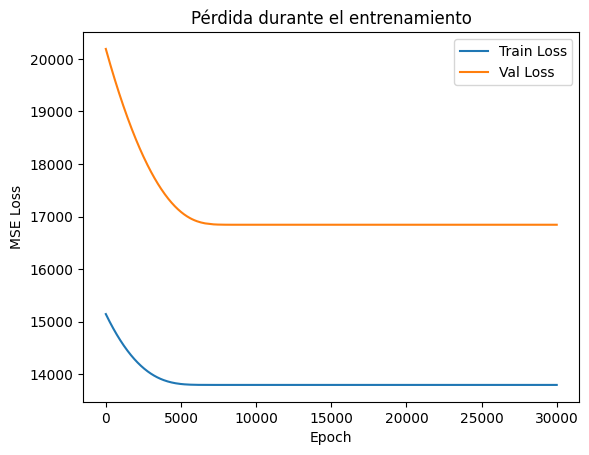

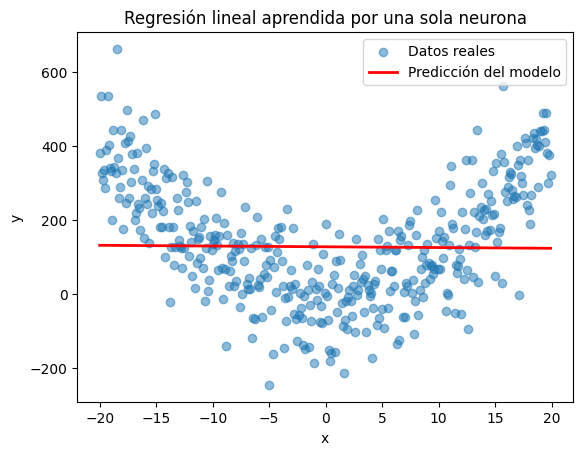

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Pérdida durante el entrenamiento")
plt.legend()
plt.show()

x_all_scaled = ss.transform(x.reshape(-1, 1))
X_all = torch.tensor(x_all_scaled, dtype=torch.float32).to("cuda")
with torch.no_grad():
    y_pred_all = model(X_all).cpu().numpy()

plt.scatter(x, y, label="Datos reales", alpha=0.5)
plt.plot(x, y_pred_all, color='red', label="Predicción del modelo", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regresión lineal aprendida por una sola neurona")
plt.legend()
plt.show()

Defimos otro modelo de una sola capa oculta de n neuronas. Es decir, una cadena de n+1 (creo) segmentos rectilieos.

In [ ]:
class UnaCapa(nn.Module):
    """Red neuronal con una sola capa oculta. Activación ReLU"""
    def __init__(self, hidden_units=10):
        super(UnaCapa, self).__init__()
        self.hidden = nn.Linear(1,hidden_units)
        self.activation = nn.ReLU()
        self.linear = nn.Linear(hidden_units, 1)
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.linear(x)
        return x

In [ ]:
model = UnaCapa(hidden_units=1000).to("cuda")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=10)
epochs = 10000
train_losses, val_losses = [], []

In [ ]:
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)
        val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")



Epoch    0 | Train Loss: 1503961472.0000 | Val Loss: 4414905856.0000
Epoch  100 | Train Loss: 1026672448.0000 | Val Loss: 1597609856.0000
Epoch  200 | Train Loss: 442009696.0000 | Val Loss: 384539136.0000
Epoch  300 | Train Loss: 346868448.0000 | Val Loss: 297967392.0000
Epoch  400 | Train Loss: 509701440.0000 | Val Loss: 1103557760.0000
Epoch  500 | Train Loss: 329220448.0000 | Val Loss: 279817536.0000
Epoch  600 | Train Loss: 333529504.0000 | Val Loss: 291499840.0000
Epoch  700 | Train Loss: 330455712.0000 | Val Loss: 289450336.0000
Epoch  800 | Train Loss: 332037472.0000 | Val Loss: 280782400.0000
Epoch  900 | Train Loss: 322063488.0000 | Val Loss: 270925888.0000
Epoch 1000 | Train Loss: 324100416.0000 | Val Loss: 268351232.0000
Epoch 1100 | Train Loss: 320615776.0000 | Val Loss: 265075408.0000
Epoch 1200 | Train Loss: 404821760.0000 | Val Loss: 295869440.0000
Epoch 1300 | Train Loss: 319794240.0000 | Val Loss: 263182448.0000
Epoch 1400 | Train Loss: 325070432.0000 | Val Loss: 29435

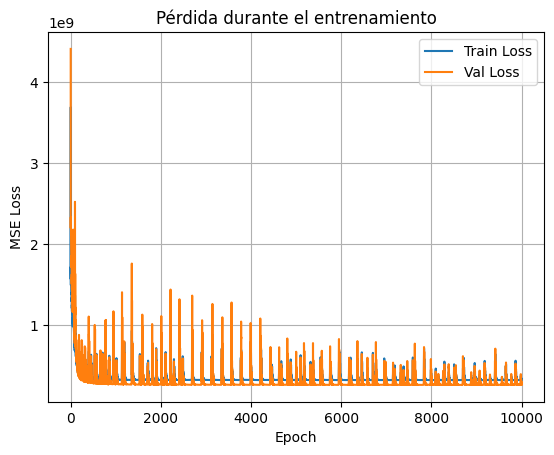

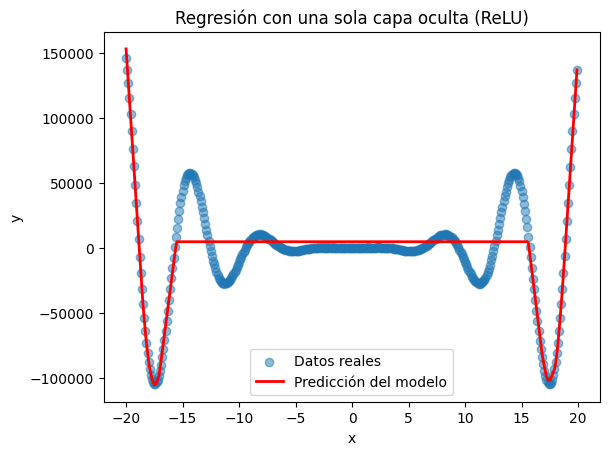

In [ ]:
#plt.figure(dpi=300)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Pérdida durante el entrenamiento")
#plt.ylim(75, 200)
plt.legend()
plt.grid()
plt.show()

x_all_scaled = ss.transform(x.reshape(-1, 1))
X_all = torch.tensor(x_all_scaled, dtype=torch.float32).to("cuda")
with torch.no_grad():
    y_pred_all = model(X_all).cpu().numpy()

plt.figure(dpi=100)
plt.scatter(x, y, label="Datos reales", alpha=0.5)
plt.plot(x, y_pred_all, color='red', label="Predicción del modelo", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regresión con una sola capa oculta (ReLU)")
plt.legend()
plt.show()